In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import html
import urllib

Reading data
------------

In [8]:
graphs_path = './data/wikispeedia_paths-and-graph/'
link_network_pos = pd.read_pickle('link_network_w_position.df')
finished_paths = pd.read_pickle('finished_paths_w_positions.df')
unfinished_paths = pd.read_pickle('unfinished_paths_w_positions.df')

In [9]:
#graphs_path = './data/wikispeedia_paths-and-graph/'
!ls data/wikispeedia_paths-and-graph/

articles.tsv	links.tsv	    paths_unfinished.tsv
categories.tsv	paths_finished.tsv


In [10]:
!head './data/wikispeedia_paths-and-graph/categories.tsv'

# Hierarchical categories of all articles.
# Many articles have more than one category. Some articles have no category.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# FORMAT:   article   category
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:


In [11]:
def read_tsv(file_name, names=None):
    
    file_path = graphs_path + f'{file_name}.tsv'
    
    if not names:
        with open(file_path, 'r') as file:
            for line in file:
                if 'FORMAT' in line:
                    format_line = line
                    break

        names = format_line.split()[2:]
    
    return pd.read_csv(file_path,
                           delimiter='\t', comment='#', header=0, names=names)

In [12]:
link_network = read_tsv('links', names=['source', 'target'])
display(link_network.head(5))
link_network.shape

# link_network = link_network.applymap(urllib.parse.unquote_plus).copy()

,source,target
0,linkSource,linkTarget
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain


(119883, 2)

In [13]:
categories = read_tsv('categories')
display(categories.head(5))
categories.shape


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
1,%C3%85land,subject.Countries
2,%C3%85land,subject.Geography.European_Geography.European_...
3,%C3%89douard_Manet,subject.People.Artists
4,%C3%89ire,subject.Countries


(5203, 2)

In [14]:
finished_paths = read_tsv('paths_finished')
display(finished_paths.head(5))
finished_paths.shape

,hashedIpAddress,timestamp,durationInSec,path,rating
0,"# Articles in a path are separated by "";"".",NaN,NaN,NaN,NaN
1,"# Back clicks are represented as ""<"".",NaN,NaN,NaN,NaN
2,# Ratings are optionally given by the user aft...,NaN,NaN,NaN,NaN
3,"# Missing ratings are represented as ""NULL"".",NaN,NaN,NaN,NaN
4,hashedIpAddress,timestamp,durationInSec,path,rating


(51323, 5)

In [15]:
unfinished_paths = read_tsv('paths_unfinished')
display(unfinished_paths.head(5))
unfinished_paths.shape

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
1,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
2,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
3,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
4,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout


(24874, 6)

In [16]:
articles = read_tsv('articles')
display(articles.head(5))
articles.shape

,article
0,%C3%85land
1,%C3%89douard_Manet
2,%C3%89ire
3,%C3%93engus_I_of_the_Picts
4,%E2%82%AC2_commemorative_coins


(4603, 1)

Pre-processing
--------------

In [17]:
# count number of incoming and outgoing links

source_counts = link_network['source'].value_counts().rename_axis('article').reset_index(name='source_count')
target_counts = link_network['target'].value_counts().rename_axis('article').reset_index(name='target_count')

link_counts = pd.merge(source_counts, target_counts, how='outer')
link_counts.fillna(0, inplace=True)

In [18]:
link_counts['target_source_ratio'] = link_counts['target_count'] / link_counts['source_count']
link_counts['target_source_ratio'].replace([np.inf], np.nan, inplace=True)

display(link_counts.head(5))
link_counts.shape

,article,source_count,target_count,target_source_ratio
0,United_States,294.0,1551.0,5.275510
1,Driving_on_the_left_or_right,255.0,0.0,0.000000
2,List_of_countries,244.0,63.0,0.258197
3,List_of_circulating_currencies,236.0,8.0,0.033898
4,List_of_sovereign_states,216.0,43.0,0.199074


(4594, 4)

In [22]:
import uuid
import os
import urllib.parse
from bs4 import BeautifulSoup, Comment

def gen_uniq_str(str_):
    return uuid.uuid4().hex[:len(str_)+1]

def find_html_position(source, targets):
    article_quote = source
    with open('data/wpcd/wp/{}/{}.htm'.format(article_quote[0].lower(), article_quote)) as f:
        try:
            art_html = f.read()
        except:
            print(source)
            return -1

    soup = BeautifulSoup(art_html, features="html.parser")
    for script in soup(["script", "style", "head"]):
        script.extract()    # rip it out

    comments = soup.findAll(string=lambda string:isinstance(string, Comment))
    for comment in comments:
        comment.extract()
        
    locators = []
    
    for tgt in targets:
        try:
            locator = gen_uniq_str(urllib.parse.unquote_plus(tgt))
            locators.append(locator)
            #soup.find('a', attrs={'title': tgt.replace("_", " ")}).replace_with(locator)
            
            soup.select_one(f'a[href*="/{urllib.parse.quote_plus(tgt)}.htm"]').replace_with(locator)
        except Exception as e:
            k = f'a[href*="{urllib.parse.quote_plus(tgt)}.htm"]'
            print(k)
            print(source, tgt)
            pass
    
    text = " ".join(soup.text.split())
    
    pos = {}
    for iloc, loc in enumerate(locators):
        pos[targets[iloc]] = text.find(loc)/len(text)
        
    return pos

In [24]:
with open("data/wpcd/wp/1/11th_century.htm") as fp:
    soup = BeautifulSoup(fp, 'html.parser')
    
for script in soup(["script", "style", "head"]):
    script.extract()    # rip it out

comments = soup.findAll(string=lambda string:isinstance(string, Comment))
for comment in comments:
    comment.extract()
    
soup.select_one('a[href*="Nigeria.htm"]').replace_with("sdf")
soup.select_one('a[href*="Norman_conquest_of_England.htm"]')

FileNotFoundError: [Errno 2] No such file or directory: 'data/wpcd/wp/1/11th_century.html'

In [185]:
row = link_network_targets.query('source == "11th_century"').iloc[0]
find_html_position(row['source'], row['target'])

{'10th_century': 0.021573604060913704,
 '12th_century': 0.025944726452340666,
 '13th_century': 0.9242808798646363,
 '14th_century': 0.9262549351381839,
 '15th_century': 0.9282289904117316,
 '16th_century': 0.9302030456852792,
 '17th_century': 0.9321771009588269,
 '18th_century': 0.9341511562323745,
 '19th_century': 0.9361252115059222,
 '1st_century': 0.9049633389734912,
 '1st_century_BC': 0.9020022560631697,
 '20th_century': 0.9380992667794699,
 '21st_century': 0.9407783417935702,
 '2nd_century': 0.9067963902989283,
 '3rd_century': 0.9086294416243654,
 '4th_century': 0.9104624929498026,
 '5th_century': 0.9122955442752397,
 '6th_century': 0.9141285956006768,
 '7th_century': 0.9159616469261139,
 '8th_century': 0.917794698251551,
 '9th_century': 0.9196277495769881,
 'Battle_of_Hastings': 0.37408347433728145,
 'Byzantine_Empire': 0.20727580372250423,
 'Canute_the_Great': 0.6603214890016921,
 'China': 0.7329385222786238,
 'Crusades': 0.14438804286520024,
 'Dark_Ages': 0.1042019176536943,
 '

In [194]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

link_network = filter_rows_by_values(link_network, 'source', ['Friend_Directdebit', 'Sponsorship_Directdebit'])
link_network_targets = link_network.groupby('source')['target'].apply(list).reset_index()

In [195]:
# Add the 'html_position' column to the DataFrame
link_network_targets['html_position'] = link_network_targets.apply(
    lambda row: find_html_position(row['source'], row['target']), axis=1
)


a[href*="Genghis_Khan.htm"]
Genghis_Khan Genghis_Khan
a[href*="Germany.htm"]
List_of_European_Union_member_states_by_accession Germany
a[href*="Ireland.htm"]
List_of_European_Union_member_states_by_accession Ireland


In [196]:
display(link_network_targets.head(5))
link_network_targets.shape

,source,target,html_position
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[Columba, D%C3%A1l_Riata, Great_Britain, Irela...","{'Columba': 0.0374586852735953, 'D%C3%A1l_Riat..."
1,%C3%85land,"[20th_century, Baltic_Sea, Crimean_War, Curren...","{'20th_century': 0.4077241923810777, 'Baltic_S..."
2,%C3%89douard_Manet,"[Absinthe, Beer, Claude_Monet, Diego_Vel%C3%A1...","{'Absinthe': 0.11527492584987452, 'Beer': 0.60..."
3,%C3%89ire,"[Canada, English_language, George_VI_of_the_Un...","{'Canada': 0.4879246498148446, 'English_langua..."
4,%C3%93engus_I_of_the_Picts,"[D%C3%A1l_Riata, Durham, England, Great_Britai...","{'D%C3%A1l_Riata': 0.08427483471420202, 'Durha..."


(4585, 3)

In [208]:
m = pd.DataFrame([*link_network_targets['html_position']], link_network_targets.index).stack()\
      .rename_axis([None,'target']).reset_index(1, name='position')

link_network_pos = link_network_targets[['source']].join(m)

In [209]:
link_network_pos = pd.merge(link_network, link_network_pos, on=['source', 'target'], how='left')
link_network_pos.to_pickle('link_network_w_position.df')
display(link_network_pos.head(5))
link_network_pos.shape

,source,target,position
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,0.037459
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,0.025523
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,0.058024
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,0.032042
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,0.063349


(119878, 3)

In [221]:
def calculate_positions(arts):
    if '<' in arts: return [float('nan')]
    articles = arts.split(';')
    
    if len(articles) < 2: return [float('nan')]
    
    positions = []
    
    art_idx = 0
    
    for idx, art in enumerate(articles[1:]):
        art0 = articles[art_idx]
        try:          
            positions.append(link_network_pos[(link_network_pos['source'] == art0)
                            & (link_network_pos['target'] == art)]['position'].values[0])
            art_idx = idx+1
        except:
            print(art0, art, arts)
            return [float('nan')]
    
    return positions

In [ ]:
finished_paths['link_positions'] = finished_paths['path'].apply(calculate_positions)
unfinished_paths['link_positions'] = unfinished_paths['path'].apply(calculate_positions)

In [338]:
def get_avg_duration(row):
    num_steps = len(row['path'].split(';')) - 1
    return np.nan if num_steps <= 0 else row['durationInSec'] / num_steps

finished_paths['avg_duration'] = finished_paths.apply(get_avg_duration, axis=1)
unfinished_paths['avg_duration'] = unfinished_paths.apply(get_avg_duration, axis=1)

In [234]:
finished_paths['avg_position'] = finished_paths['link_positions'].apply(
    lambda x: np.mean(x) if x else np.nan)
unfinished_paths['avg_position'] = unfinished_paths['link_positions'].apply(
    lambda x: np.mean(x) if x else np.nan)

finished_paths['max_position'] = finished_paths['link_positions'].apply(
    lambda x: np.max(x) if x else np.nan)
unfinished_paths['max_position'] = unfinished_paths['link_positions'].apply(
    lambda x: np.max(x) if x else np.nan)

# Preliminary analysis


## Categories

In [188]:
main_cat_set = set()
sec_cat_set = set()
thrd_cat_set = set()

for cat in categories['category']:
    levels = cat.split('.')
    if len(levels) > 1:
        main_cat_set.add(levels[1])
    if len(levels) > 2:
        sec_cat_set.add(levels[2])
    if len(levels) > 3:
        thrd_cat_set.add(levels[3])

print(f'There are {len(main_cat_set)} unique main categories, {len(sec_cat_set)} unique second level categories, and {len(thrd_cat_set)} unique third level categories.')


There are 15 unique main categories, 101 unique second level categories, and 27 unique third level categories.


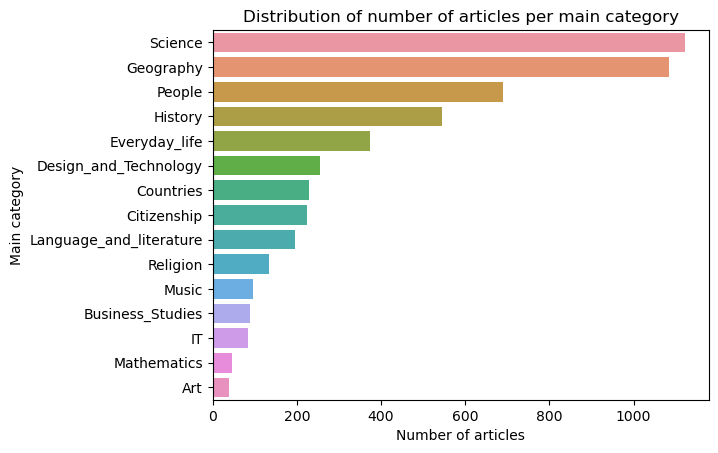

In [218]:
categories['main_category'] = categories['category'].str.split('.').str[1]
article_counts = categories['main_category'].value_counts()

sns.barplot(x=article_counts.values, y=article_counts.index, orient='horizontal')
plt.ylabel('Main category')
plt.xlabel('Number of articles')
plt.title('Distribution of number of articles per main category')
plt.show()

## Link counts to and from each article

In [211]:
link_counts.describe()

,source_count,target_count,target_source_ratio
count,4592.000000,4592.000000,4587.000000
mean,26.106490,26.106490,0.859391
std,24.196551,62.814634,1.439986
min,0.000000,0.000000,0.000000
25%,11.000000,2.000000,0.166667
50%,19.000000,8.000000,0.470588
75%,33.000000,25.000000,1.040213
max,294.000000,1551.000000,42.250000


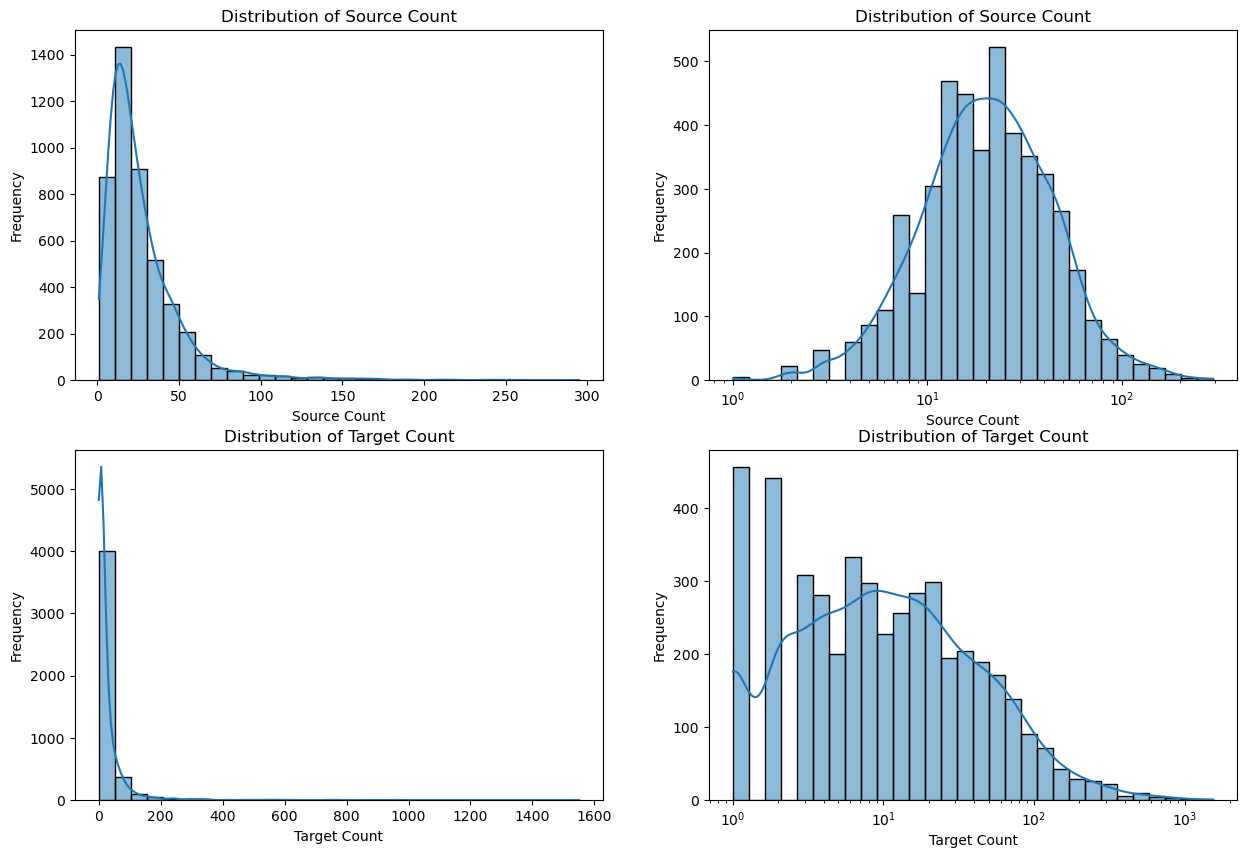

In [243]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

ax = axs[0, 0]

sns.histplot(link_counts['source_count']+1, bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Source Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Source Count')

ax = axs[0, 1]

sns.histplot(link_counts['source_count']+1, bins=30, kde=True, log_scale=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Source Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Source Count')

ax = axs[1, 0]

sns.histplot(link_counts['target_count'], bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Count')


ax = axs[1, 1]

sns.histplot(link_counts['target_count']+1, bins=30, kde=True, log_scale=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Count')

plt.show()


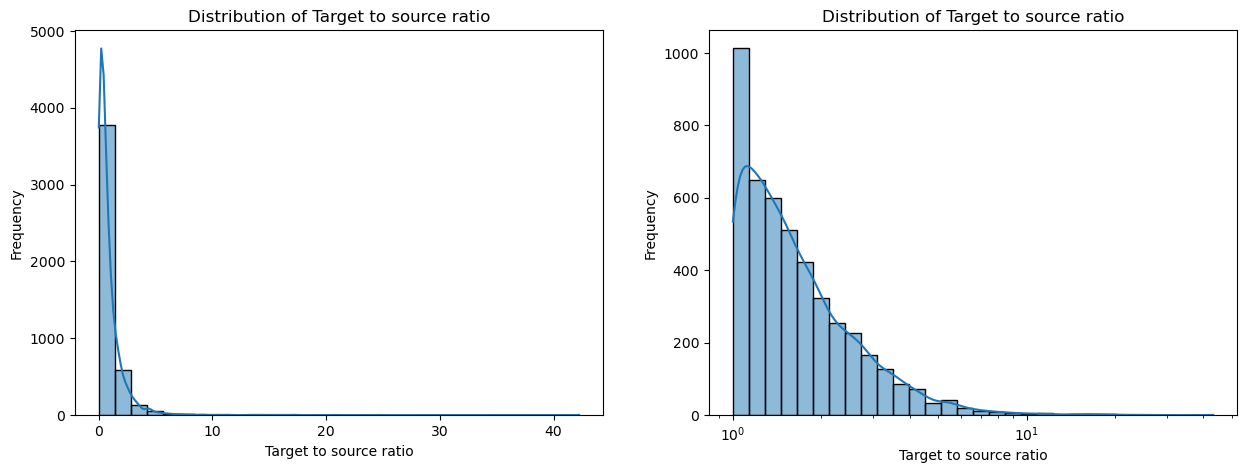

In [219]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

ax = axs[0]

sns.histplot(link_counts['target_source_ratio'], bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target to source ratio')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target to source ratio')

ax = axs[1]

sns.histplot(link_counts['target_source_ratio']+1, bins=30, log_scale=True, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target to source ratio')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target to source ratio')

plt.show()

In [227]:
source_25th_percentile = link_counts['source_count'].quantile(0.75)
target_25th_percentile = link_counts['target_count'].quantile(0.75)

hubs = link_counts[
    (link_counts['source_count'] >= source_25th_percentile) &
    (link_counts['target_count'] >= target_25th_percentile)
]

In [231]:
hubs_categories = pd.merge(hubs, categories, on='article')

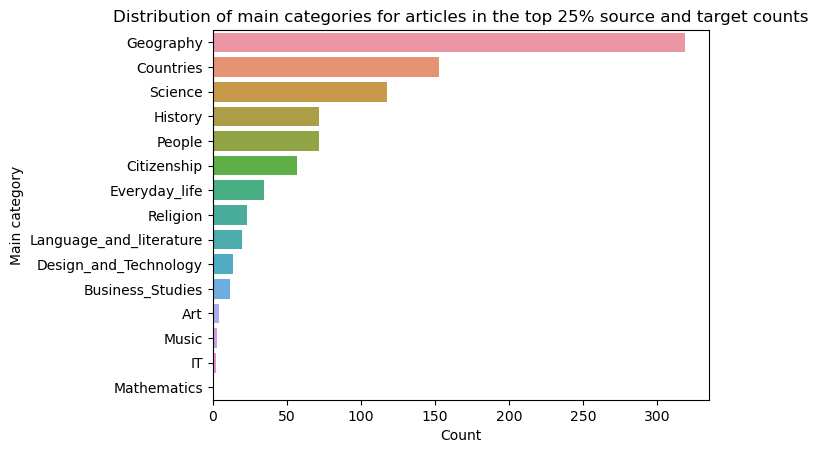

In [234]:
sns.countplot(data=hubs_categories, y='main_category', order=hubs_categories['main_category'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Main category')
plt.title('Distribution of main categories for articles in the top 25% source and target counts')
plt.show()


## Identify hubs from finished paths

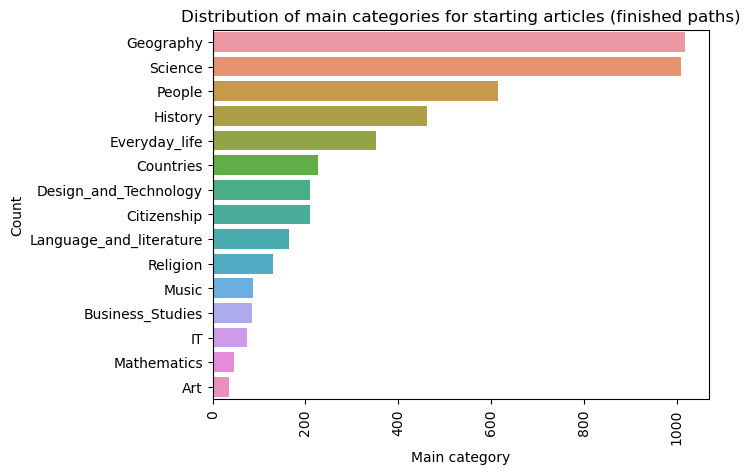

In [275]:
from collections import Counter
starting_articles = [i.split(';')[0] for i in finished_paths['path'].tolist()]
starting_categories = categories[categories['article'].isin(starting_articles)]

sns.countplot(data=starting_categories, y='main_category', order=starting_categories['main_category'].value_counts().index)
plt.xlabel('Main category')
plt.ylabel('Count')
plt.title('Distribution of main categories for starting articles (finished paths)')
plt.xticks(rotation=90)
plt.show()

In [333]:
from collections import Counter

all_paths = [i.split(';')[1:-1] for i in finished_paths['path'].tolist()]
all_articles = [article for path in all_paths for article in path]

article_counter = Counter(all_articles)
del article_counter['<']

# Most visited
top_hub_articles = [article for article, count in article_counter.most_common(100)]
top_hub_articles[:20]

['United_States',
 'Europe',
 'United_Kingdom',
 'Earth',
 'England',
 'Africa',
 'World_War_II',
 'North_America',
 'Germany',
 'Animal',
 'Mammal',
 'Human',
 'France',
 'Science',
 'English_language',
 'Periodic_table',
 'Computer',
 'Atlantic_Ocean',
 'India',
 'Agriculture']

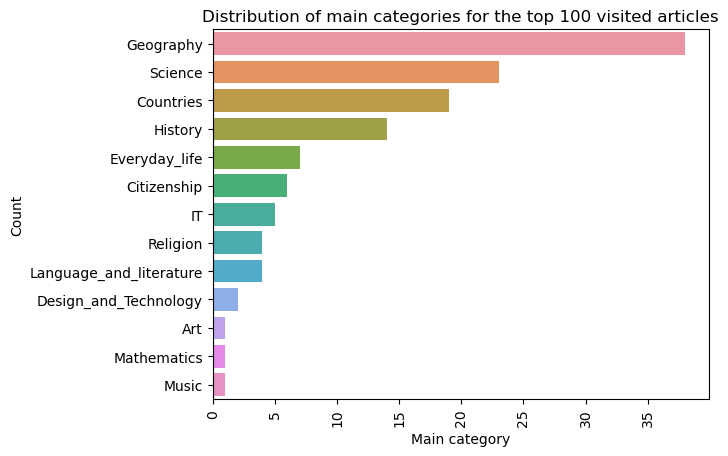

In [328]:
top_hub_categories = categories[categories['article'].isin(top_hub_articles)]

sns.countplot(data=top_hub_categories, y='main_category', order=top_hub_categories['main_category'].value_counts().index)
plt.xlabel('Main category')
plt.ylabel('Count')
plt.title('Distribution of main categories for the top 100 visited articles')
plt.xticks(rotation=90)
plt.show()

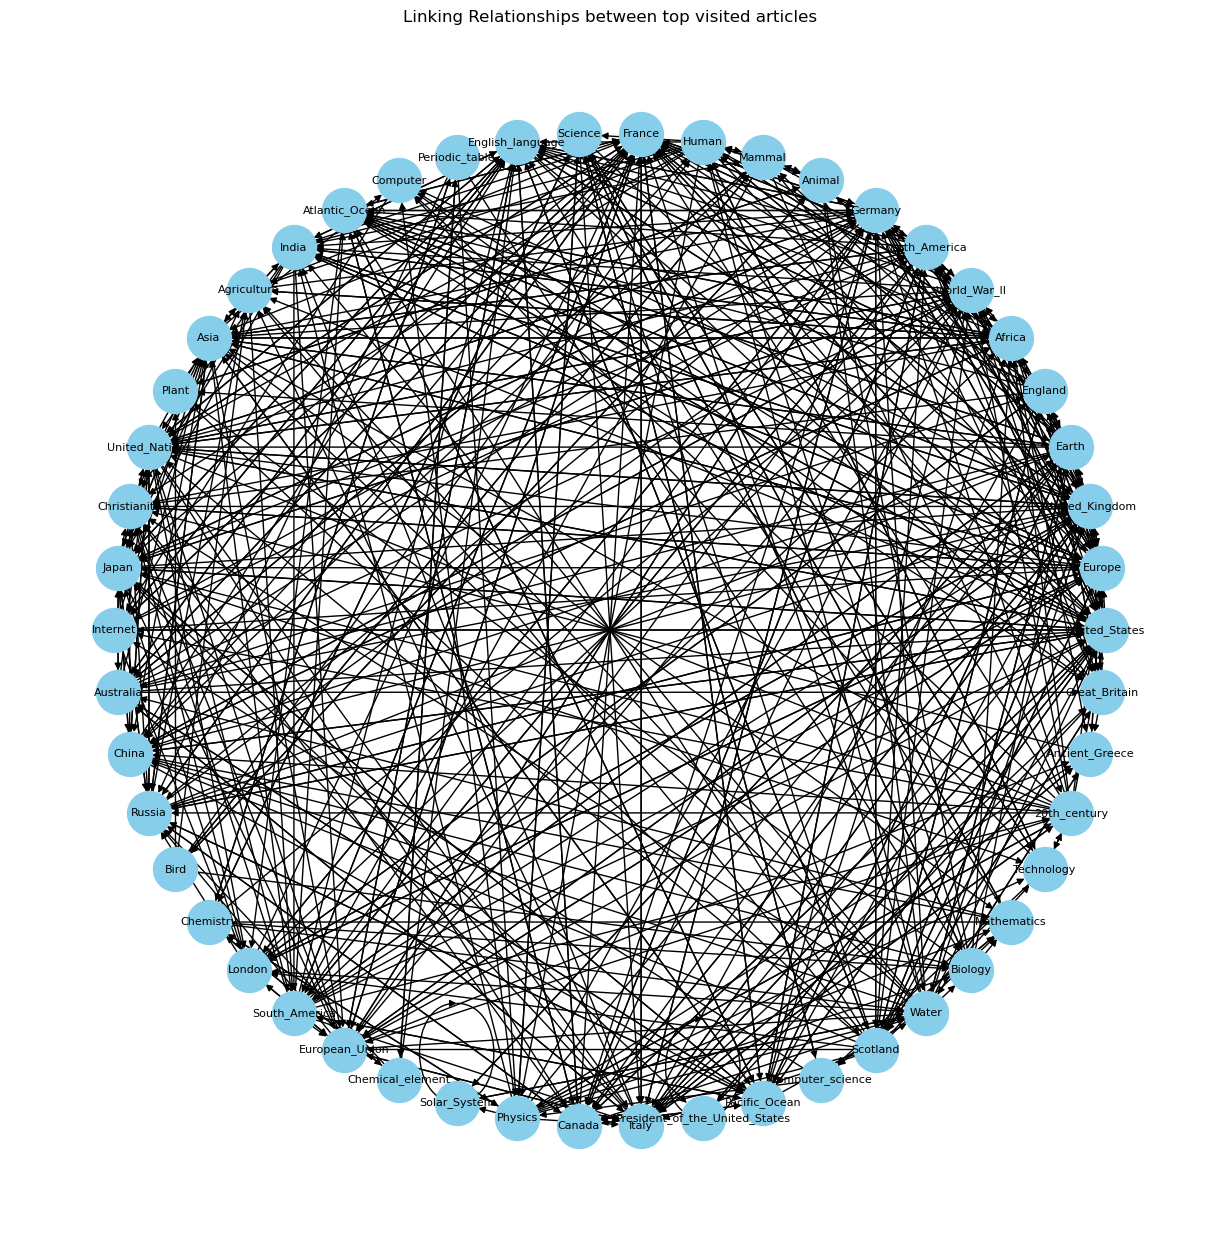

In [335]:
G = nx.DiGraph()

G.add_nodes_from(top_hub_articles[:50])

# Filter links that involve the top hub articles
filtered_links = link_network_pos[(link_network_pos['source'].isin(top_hub_articles[:50])
                                  ) & (link_network_pos['target'].isin(top_hub_articles[:50]))]

# Add edges between top hub articles
for _, row in filtered_links.iterrows():
    G.add_edge(row['source'], row['target'])


pos = nx.circular_layout(G, scale=1)

plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=8)
plt.title('Linking Relationships between top visited articles')
plt.show()

## Position of links within the article

In [16]:
link_network_pos.describe()

,position
count,119878.000000
mean,0.405405
std,0.318017
min,-0.000080
25%,0.098042
50%,0.351382
75%,0.689618
max,0.995548


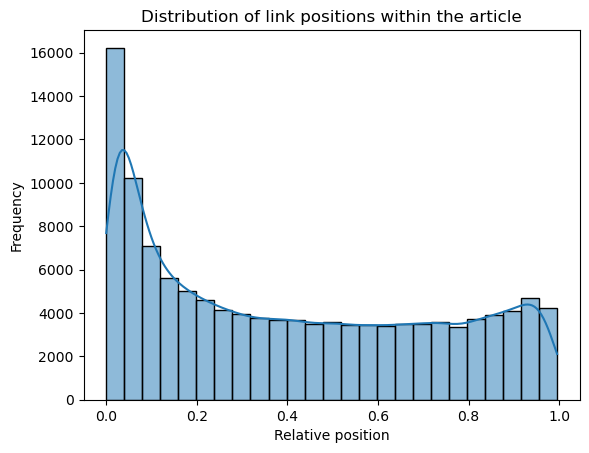

In [27]:
sns.histplot(data=link_network_pos, x='position', bins=25, kde=True)  # You can adjust the number of bins as needed
plt.title('Distribution of link positions within the article')
plt.xlabel('Relative position')
plt.ylabel('Frequency')
plt.show()

## Link positions vs. game duration (for finished and unfinished paths)

In [103]:
finished_paths.describe()

,timestamp,durationInSec,rating,avg_duration,avg_position,max_position
count,5.131700e+04,51317.000000,28501.000000,51317.000000,42307.000000,42307.000000
mean,1.296384e+09,158.276049,2.269780,22.352658,0.265564,0.592498
std,4.935134e+07,360.845419,1.110439,49.920621,0.154535,0.283027
min,1.219095e+09,0.000000,1.000000,0.000000,0.001663,0.001663
25%,1.250109e+09,60.000000,1.000000,11.571429,0.148665,0.364372
50%,1.283894e+09,107.000000,2.000000,17.461538,0.249552,0.638645
75%,1.345232e+09,183.000000,3.000000,26.000000,0.357770,0.845849
max,1.389823e+09,35091.000000,5.000000,4665.200000,0.988849,0.994416


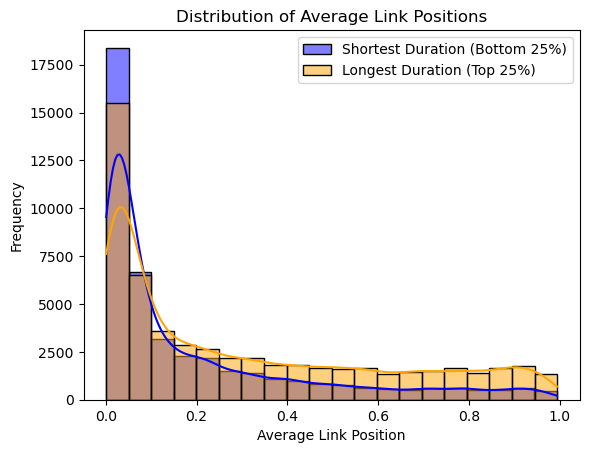

In [113]:
bottom_25_threshold = finished_paths['avg_duration'].quantile(0.25)
top_25_threshold = finished_paths['avg_duration'].quantile(0.75)

shortest_duration_positions = [position for positions in finished_paths[finished_paths['avg_duration'] <= bottom_25_threshold]['link_positions'] for position in positions]
longest_duration_positions = [position for positions in finished_paths[finished_paths['avg_duration'] >= top_25_threshold]['link_positions'] for position in positions]

sns.histplot(shortest_duration_positions, bins=20, kde=True, label='Shortest Duration (Bottom 25%)', color='blue', alpha=0.5)
sns.histplot(longest_duration_positions, bins=20, kde=True, label='Longest Duration (Top 25%)', color='orange', alpha=0.5)

plt.xlabel('Average Link Position')
plt.ylabel('Frequency')
plt.title('Distribution of Average Link Positions')

plt.legend()
plt.show()


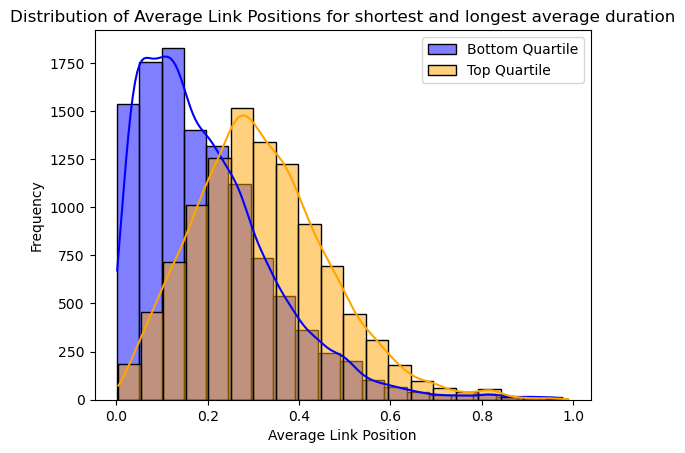

In [175]:
bottom_25_threshold = finished_paths['avg_duration'].quantile(0.25)
top_25_threshold = finished_paths['avg_duration'].quantile(0.75)

bottom_quartile_positions = finished_paths[finished_paths['avg_duration'] <= bottom_25_threshold]['avg_position']
top_quartile_positions = finished_paths[finished_paths['avg_duration'] >= top_25_threshold]['avg_position']

sns.histplot(bottom_quartile_positions, bins=20, kde=True, label='Bottom Quartile', color='blue', alpha=0.5)
sns.histplot(top_quartile_positions, bins=20, kde=True, label='Top Quartile', color='orange', alpha=0.5)

plt.xlabel('Average Link Position')
plt.ylabel('Frequency')
plt.title('Distribution of Average Link Positions for shortest and longest average duration')

plt.legend()
plt.show()


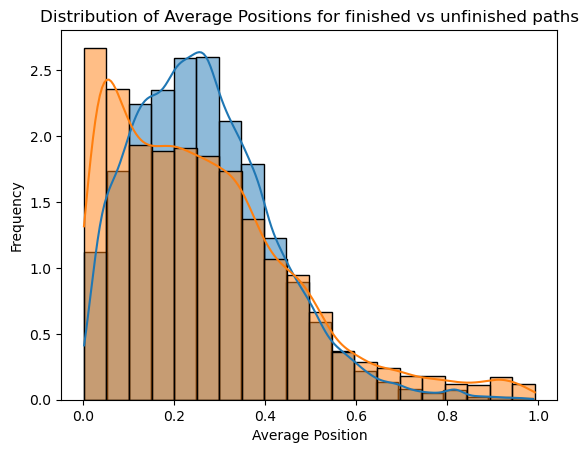

In [180]:
sns.histplot(data=finished_paths, x='avg_position', bins=20, kde=True, stat='density')
sns.histplot(data=unfinished_paths, x='avg_position', bins=20, kde=True, stat='density')

plt.xlabel('Average Position')
plt.ylabel('Frequency')
plt.title('Distribution of Average Positions for finished vs unfinished paths')

plt.show()

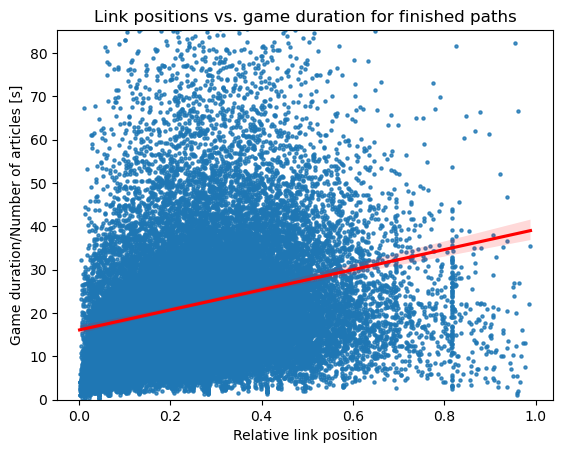

In [49]:
sns.regplot(y='avg_duration', x='avg_position', data=finished_paths, ci=95, line_kws={'color': 'red'},
            scatter_kws={'s': 5})
plt.ylabel('Game duration/Number of articles [s]')
plt.xlabel('Relative link position')
plt.ylim(0, finished_paths.avg_duration.quantile(0.99))
plt.title('Link positions vs. game duration for finished paths');

<Axes: xlabel='type', ylabel='count'>

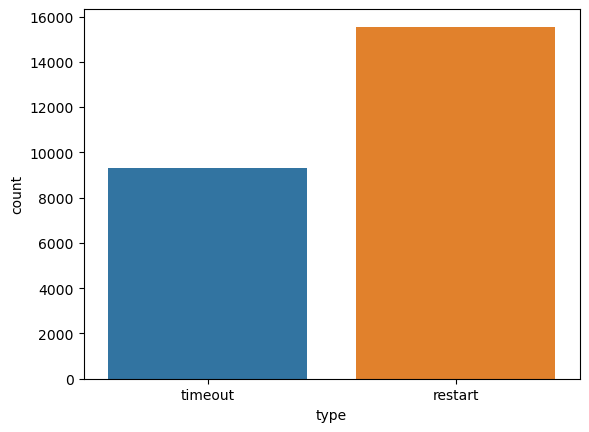

In [53]:
# Type of unfinished paths
sns.countplot(unfinished_paths, x="type")

In [75]:
# Compute the link positions for 'timeout' type
timeout_paths = unfinished_paths[unfinished_paths['type'] == 'timeout']

# Compute the link positions for 'restart' type
restart_paths = unfinished_paths[unfinished_paths['type'] == 'restart']


In [78]:
unfinished_paths.describe()

,timestamp,durationInSec,avg_duration,max_position,avg_position
count,2.487400e+04,24874.000000,24874.000000,14403.000000,14403.000000
mean,1.344765e+09,835.257940,311.256952,0.494428,0.265217
std,2.772208e+07,881.284271,507.813700,0.323777,0.202981
min,1.297056e+09,4.000000,2.000000,0.001334,0.001334
25%,1.320341e+09,86.000000,22.500000,0.178362,0.100774
50%,1.348587e+09,261.000000,46.000000,0.497656,0.230330
75%,1.367373e+09,1831.000000,379.000000,0.798926,0.373860
max,1.389823e+09,9089.000000,1962.000000,0.994416,0.992687


In [79]:
restart_paths.describe()

,timestamp,durationInSec,avg_duration,max_position,avg_position
count,1.555200e+04,15552.000000,15552.000000,8848.000000,8848.000000
mean,1.345831e+09,176.575296,38.041937,0.501969,0.264894
std,2.726300e+07,222.267962,64.544327,0.323732,0.200242
min,1.297095e+09,4.000000,2.000000,0.001334,0.001334
25%,1.324356e+09,48.000000,16.888889,0.185166,0.103084
50%,1.349253e+09,114.000000,26.600000,0.514357,0.233267
75%,1.367435e+09,224.000000,41.000000,0.806089,0.370505
max,1.389823e+09,5263.000000,1733.000000,0.994416,0.990781


In [80]:
timeout_paths.describe()

,timestamp,durationInSec,avg_duration,max_position,avg_position
count,9.322000e+03,9322.000000,9322.000000,5555.000000,5555.000000
mean,1.342987e+09,1934.145784,767.064709,0.482417,0.265733
std,2.838401e+07,241.892160,590.640342,0.323517,0.207286
min,1.297056e+09,1129.000000,30.323171,0.002269,0.002269
25%,1.313591e+09,1817.000000,315.166667,0.167470,0.096973
50%,1.346746e+09,1864.000000,545.125000,0.477419,0.224978
75%,1.367057e+09,1959.000000,922.000000,0.790840,0.378769
max,1.389799e+09,9089.000000,1962.000000,0.994191,0.992687


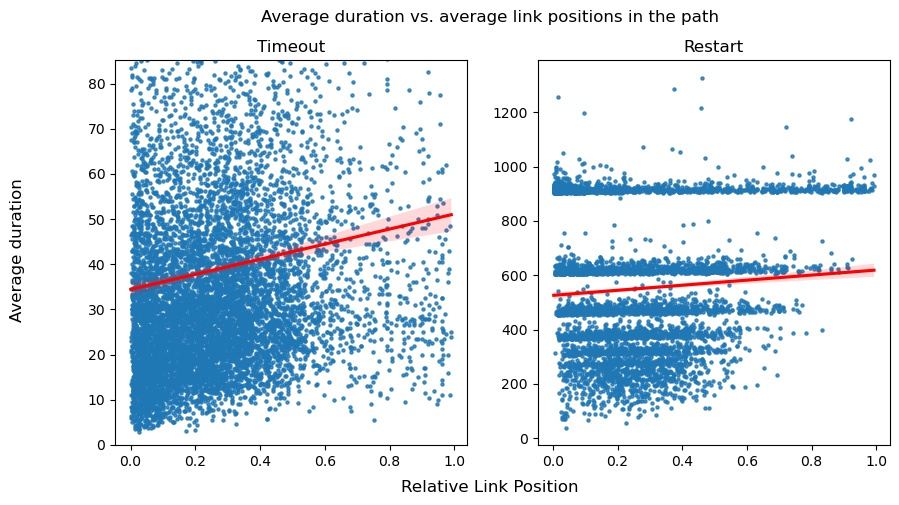

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


sns.regplot(y='avg_duration', x='avg_position', data=restart_paths, ci=95, line_kws={'color': 'red'},
            scatter_kws={'s': 5}, ax=ax1)


ax1.set_ylim(0, finished_paths.avg_duration.quantile(0.99))

sns.regplot(y='avg_duration', x='avg_position', data=timeout_paths, ci=95, line_kws={'color': 'red'},
            scatter_kws={'s': 5}, ax=ax2)

ax1.set_title('Timeout')
ax2.set_title('Restart')

ax1.set_xlabel('')  # Remove x-axis label
ax1.set_ylabel('')  # Remove y-axis label
ax2.set_xlabel('')  # Remove x-axis label
ax2.set_ylabel('')  # Remove y-axis label

fig.supxlabel('Relative Link Position')
fig.supylabel('Average duration')
fig.suptitle('Average duration vs. average link positions in the path')

plt.show()

## Players who have played multiple games

In [139]:
combined_paths = pd.concat([unfinished_paths, finished_paths])

player_game_counts = combined_paths.groupby('hashedIpAddress')['path'].count().reset_index()
player_game_counts.columns = ['player_hash', 'games_count']

player_game_counts['finished_paths_count'] = player_game_counts['player_hash'].map(finished_paths['hashedIpAddress'].value_counts().fillna(0))



In [140]:
player_game_counts.describe()

,games_count,finished_paths_count
count,20866.000000,14244.000000
mean,3.651299,3.602499
std,34.929576,41.644753
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,4865.000000,4865.000000


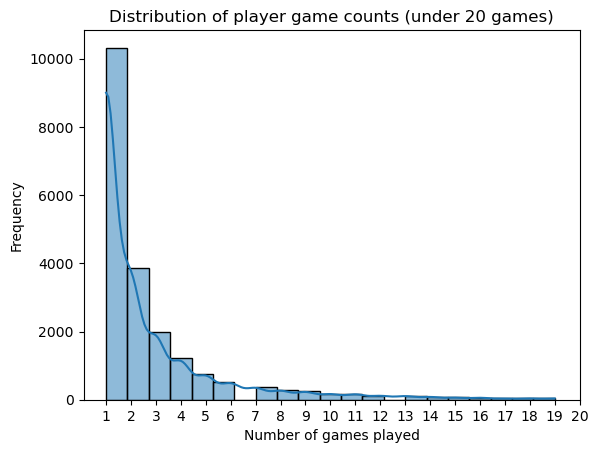

In [132]:
filtered_player_game_counts = player_game_counts[player_game_counts['games_count'] < 20]

plt.figure()

sns.histplot(data=filtered_player_game_counts, x='games_count', bins=21, kde=True)

plt.xlabel('Number of games played')
plt.ylabel('Frequency')
plt.title('Distribution of player game counts (under 20 games)')
plt.xticks(range(1, 21)) 

plt.show()

In [165]:
player_game_counts['win_ratio'] = player_game_counts['finished_paths_count'] / player_game_counts['games_count']
player_game_counts['win_ratio'].fillna(0, inplace=True)
players_with_at_least_two_games = player_game_counts[player_game_counts['games_count'] >= 2]
player_game_counts.describe()

,games_count,finished_paths_count,win_ratio
count,20866.000000,14244.000000,20866.000000
mean,3.651299,3.602499,0.569178
std,34.929576,41.644753,0.439719
min,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,2.000000,2.000000,0.666667
75%,3.000000,3.000000,1.000000
max,4865.000000,4865.000000,1.000000


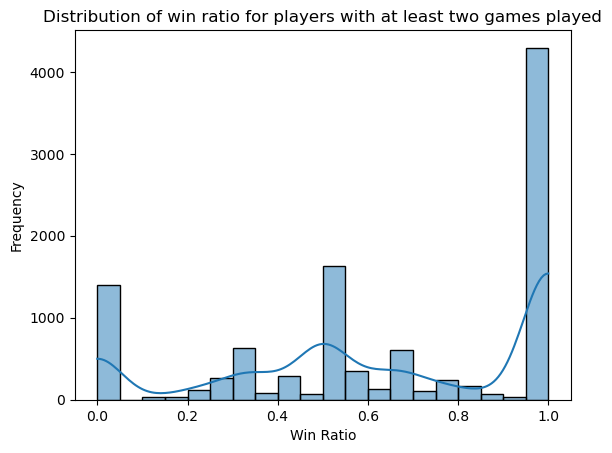

In [164]:
sns.histplot(data=players_with_at_least_two_games, x='win_ratio', bins=20, kde=True)

plt.xlabel('Win Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of win ratio for players with at least two games played')

plt.show()


# Hub Characterization Measures

In [27]:
# Create graph of wikispeedia with nodes being articles and edges being links
G_link = nx.from_pandas_edgelist(link_network, 'source', 'target', create_using=nx.DiGraph())

### Centrality Measures

#### Degree Centrality
Degree centrality measures the number of edges that connect to a node (i.e., the degree of the node). The more connections a node has, the more central it is.

For a graph \( G = (V, E) \) with \( n \) vertices, the degree centrality \( C_D(v) \) for a vertex \( v \) is defined as:
$$
C_D(v) = \frac{deg(v)}{n - 1}
$$
where \( deg(v) \) is the degree of \( v \), and \( n - 1 \) is the maximum possible degree of any vertex in a simple graph.

#### Betweenness Centrality
Betweenness centrality measures the extent to which a node lies on paths between other nodes. Nodes that frequently act as bridges between other nodes have higher betweenness centrality.

For a graph \( G = (V, E) \), the betweenness centrality \( C_B(v) \) for a vertex \( v \) is defined as:
$$
C_B(v) = \sum_{s \neq v \neq t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$
where \( \sigma_{st} \) is the total number of shortest paths from node \( s \) to node \( t \) and \( \sigma_{st}(v) \) is the number of those paths that pass through \( v \).

#### Closeness Centrality
Closeness centrality measures how close a node is to all other nodes in the graph (the sum of the shortest paths from this node to all other nodes). The idea is that nodes closer to others can spread information more efficiently.

For a connected graph \( G = (V, E) \), the closeness centrality \( C_C(v) \) for a vertex \( v \) is defined as:
$$
C_C(v) = \frac{n - 1}{\sum_{u \in V \setminus \{v\}} d(v, u)}
$$
where \( d(v, u) \) is the shortest-path distance between \( v \) and \( u \), and \( n - 1 \) is the number of nodes excluding \( v \) itself.

#### Eigenvector Centrality
Eigenvector centrality assigns relative scores to all nodes in the network based on the principle that connections to high-scoring nodes contribute more to the score of a node than equal connections to low-scoring nodes.

It is calculated by finding the eigenvector associated with the largest eigenvalue of the adjacency matrix \( A \) of the graph \( G \). If \( x \) is the eigenvector centrality of \( G \) and \( \lambda \) is the largest eigenvalue, then:
$$
Ax = \lambda x
$$
The centrality \( x_i \) of the node \( i \) is the \( i \)th element of the eigenvector \( x \).


In [28]:
# Calculating centrality measurement

# Function for Degree Centrality
def get_degree_centrality(G):
    return nx.degree_centrality(G)

# Function for Betweenness Centrality
def get_betweenness_centrality(G):
    return nx.betweenness_centrality(G)

# Function for Closeness Centrality
def get_closeness_centrality(G):
    return nx.closeness_centrality(G)

# Function for Eigenvector Centrality
def get_eigenvector_centrality(G):
    return nx.eigenvector_centrality(G)

In [29]:
# Calculate centralities for wikipedia links
degree_centrality_links = get_degree_centrality(G_link)
betweenness_centrality_links = get_betweenness_centrality(G_link)
closeness_centrality_links = get_closeness_centrality(G_link)
eigenvector_centrality_links = get_eigenvector_centrality(G_link)

# Create a DataFrame for players
centrality_df_links = pd.DataFrame({
    'Node': list(G_link.nodes()),
    'Degree Centrality': [degree_centrality_links[node] for node in G_link.nodes()],
    'Betweenness Centrality': [betweenness_centrality_links[node] for node in G_link.nodes()],
    'Closeness Centrality': [closeness_centrality_links[node] for node in G_link.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality_links[node] for node in G_link.nodes()]
})

print(centrality_df_links)

                                  Node  Degree Centrality  \
0                           linkSource           0.000218   
1                           linkTarget           0.000218   
2     %C3%81ed%C3%A1n_mac_Gabr%C3%A1in           0.002395   
3                                 Bede           0.008491   
4                              Columba           0.005008   
...                                ...                ...   
4589                      Yellowhammer           0.002830   
4590                    Yotsuya_Kaidan           0.000435   
4591            You%27re_Still_the_One           0.000435   
4592                    Yungay%2C_Peru           0.000871   
4593                        Zara_Yaqob           0.001306   

      Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  
0                   0.000000              0.000000            4.240657e-24  
1                   0.000000              0.000218            5.512854e-23  
2                   0.000000        

### Clustering Coefficients for Directed Graphs

Clustering coefficients measure the likelihood that two neighbors of a node are also neighbors of each other, forming a triangle in the graph. For directed graphs, the concept is extended to account for the directionality of connections.

#### Directed Clustering Coefficients

For a directed graph \( G = (V, E) \), the clustering coefficient can be defined for each node based on the directed triangles they participate in. There are three types of directed triangles:

- **Outgoing Triangles**: Triangles that a node \( v \) points to, i.e., \( v \) has directed edges going out to the other two nodes.
- **Incoming Triangles**: Triangles that point to the node \( v \), i.e., the other two nodes have directed edges going into \( v \).
- **Cyclic Triangles**: Triangles where the edges form a cycle, i.e., each node points to another node in a cyclic manner.

The directed clustering coefficient for a node \( v \) is typically the average of the local clustering coefficients for each type of triangle:

$$
C_{dir}(v) = \frac{1}{3} (C_{out}(v) + C_{in}(v) + C_{cycle}(v))
$$

where \( C_{out}(v) \), \( C_{in}(v) \), and \( C_{cycle}(v) \) are the local clustering coefficients for outgoing, incoming, and cyclic triangles respectively.

The local clustering coefficient for each type of triangle is calculated as:

$$
C_{type}(v) = \frac{\text{Number of triangles of a given type including } v}{\text{Number of possible triangles of that type for } v}
$$

In [37]:
# Calculate clustering coefficients according to formula above
directed_clustering_coefficient = nx.clustering(G_link)

# Put the coefficients in a list for plotting
directed_clustering_values = list(directed_clustering_coefficient.values())


### Plot distribution of each centrality measure


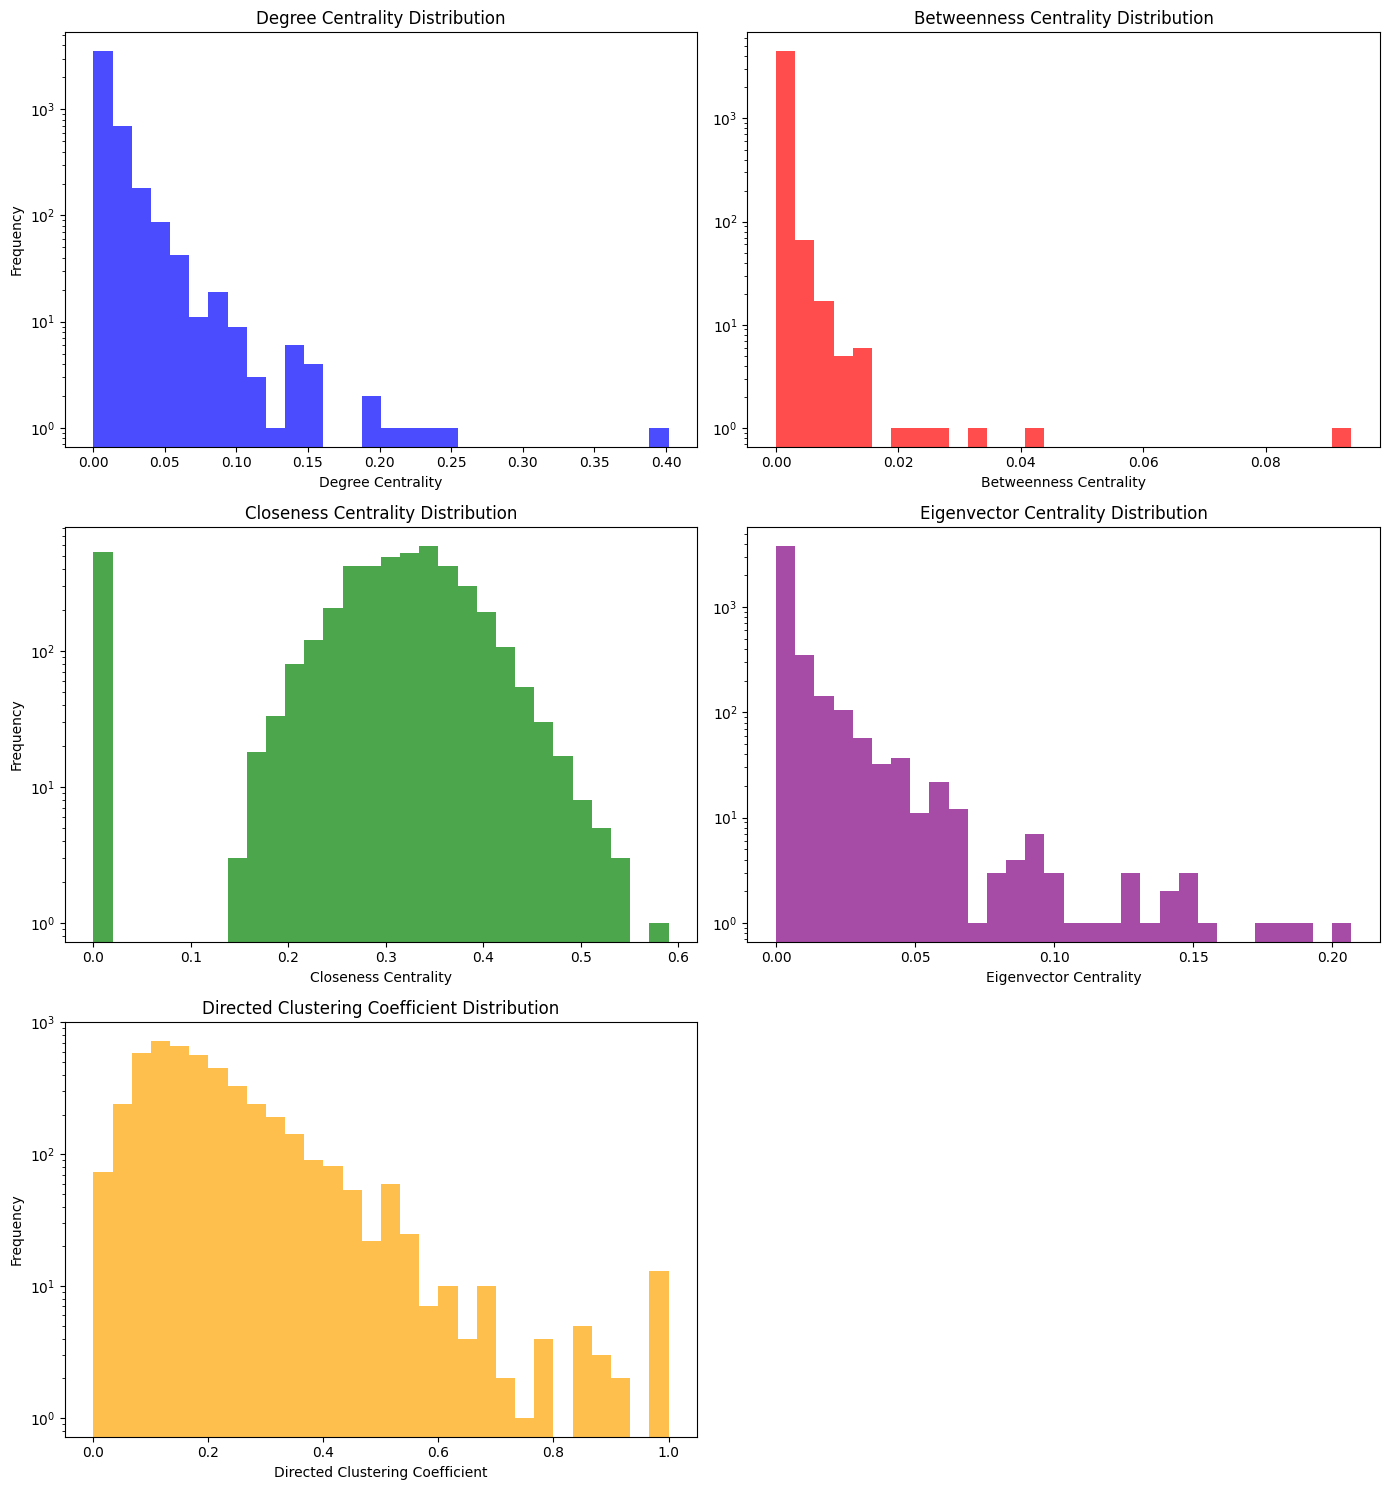

In [35]:
# Plot distribution of each centrality measure

# Set the size of the overall figure
plt.figure(figsize=(14, 15))

# Degree Centrality Distribution
plt.subplot(3, 2, 1)
plt.hist(centrality_df_links['Degree Centrality'], bins=30, color='blue', alpha=0.7,log=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

# Betweenness Centrality Distribution
plt.subplot(3, 2, 2)
plt.hist(centrality_df_links['Betweenness Centrality'], bins=30, color='red', alpha=0.7,log=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

# Closeness Centrality Distribution
plt.subplot(3, 2, 3)
plt.hist(centrality_df_links['Closeness Centrality'], bins=30, color='green', alpha=0.7, log=True)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')

# Eigenvector Centrality Distribution
plt.subplot(3, 2, 4)
plt.hist(centrality_df_links['Eigenvector Centrality'], bins=30, color='purple', alpha=0.7, log=True)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')

# Directed Clustering Coefficient Distribution
plt.subplot(3, 2, 5)  # Adjust to a 3x2 subplot grid
plt.hist(directed_clustering_values, bins=30, color='orange', alpha=0.7, log=True)
plt.title('Directed Clustering Coefficient Distribution')
plt.xlabel('Directed Clustering Coefficient')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
